In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from cycler import cycler
from mpl_toolkits import mplot3d
import glob as glob
import matplotlib.patches as mpatches

In [2]:
def density_delta(radius, r_star):
    p0 = 100
    frac_radius = r/r_star
    p = p0*(1-frac_radius**2)
    return p

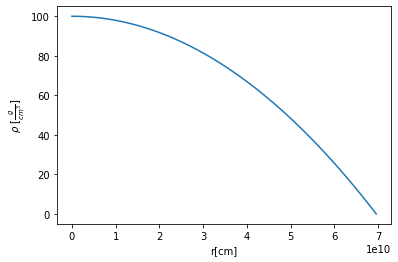

In [3]:
r = np.arange(1e-4, 6.957e10+100000, 100000)
density_d = density_delta(r, 6.957e10)
plt.plot(r, density_d, label = '$\\rho_{\delta}$')
plt.xlabel('r[cm]')
plt.ylabel('$\\rho$ [$\\frac{g}{cm^3}$]')
plt.show()

In [4]:
G = 6.67e-8
k = 1.38e-16
mu = 1.3
mp = 1.67e-24

def pressure_delta(radius, central_density, R_star): 
    """
    P_c = (176/225)*np.pi*G*R_star*central_density**2
    
    P_r = P_c - ((4*np.pi*G*(central_density**2))*((radius/3)-((8*radius**3)/(45*R_star**2))+((radius**5)/(25*R_star**4))))
    """
    P_c = (4/15)*np.pi*G*(central_density**2)*(R_star**2)
    term1 = (r**2)/6
    term2 = (2*r**4)/(15*R_star**2)
    term3 = (r**6)/(30*R_star**4)
    
    P_r = P_c - (4*np.pi*G*(central_density**2)*(term1-term2+term3))
    
    return P_r

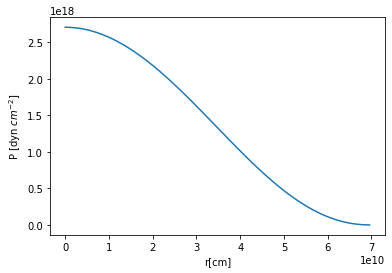

In [5]:
r = np.arange(1e-4, 6.957e10+100000, 100000)
pressure_d = pressure_delta(r, 100, 6.957e10)
plt.plot(r,pressure_d)
plt.xlabel('r[cm]')
plt.ylabel('P [dyn $cm^{-2}$]')
plt.show()

In [6]:
def temp_alpha(density, pressure):

    T_r = (mu*mp*pressure)/(k*density)
    
    return T_r

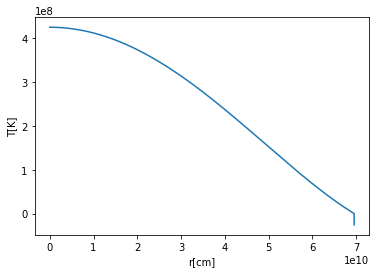

In [7]:
temp = temp_alpha(density_d, pressure_d)

plt.plot(r,temp)
plt.xlabel('r[cm]')
plt.ylabel('T[K]')
#plt.xlim(0, 0.99e11)
plt.show()

In [8]:
def rosseland_mean_opacity(density, temperature):
    X = 0.7381
    Y = 0.2485
    Z = 0.0134
    
    C_ff = 3.68e18
    gff = 1
    
    K_ff = C_ff*(X+Y)*(1+X)*(density/(temperature**3.5))
    
    C_bf = 4.34e21
    g_bf = 1
    t = 1
    
    K_bf = C_bf*(g_bf/t)*Z*(1+X)*(density/(temperature**3.5))
    
    C_es = 0.02
    K_es = C_es*(1+X)
    
    #we're able to ignore H- opacity
    """
    if temperature <= 6000 and density <= 1e-5:
        C_H_ = 7.9e-34
        K_H_ = C_H_*(Z/0.02)*(density**-0.5)*(temperature**9)
    elif temperature >= 3000 and density >= 1e-10:
        C_H_ = 7.9e-34
        K_H_ = C_H_*(Z/0.02)*(density**-0.5)*(temperature**9)
    else:
        K_H_ = 0
    
    #K = np.mean([K_ff, K_bf, K_es]) 
    #K = ((K_ff**-1)+(K_bf**-1)+(K_es**-1))**-1
    """
    K = K_ff+K_bf+K_es
    
    return K
   

In [9]:
def mean_free_path_beta(opacity, density):
    l = 1/(density*opacity)
    return l

def gaussian_mfp(l, variance, x):
    mfp = (1/np.sqrt(2*np.pi*variance))*(np.exp(-((x-l)**2))/(2*variance))
    return mfp


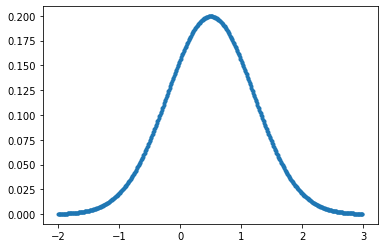

In [10]:
x_val = np.arange(-2,3,0.01)
mfp_val = gaussian_mfp(0.5, 1, x_val)
plt.plot(x_val, mfp_val, '.')
plt.show()

In [ ]:
array = np.column_stack((density_interaction, temp_interaction))


mean_path = []
for row in array: 
    rosseland_opacity = rosseland_mean_opacity(row[0], row[1])
    path = mean_free_path_beta(rosseland_opacity, row[0])
    mean_path.append(path)
plt.semilogy(r, mean_path)
plt.show()

In [11]:
#method (1): Purely random walk
N_steps = int(1e5)
N_layers = 10
N_walkers = 100
c = 3e10

x = 0
y = 0

x_val = [0]
y_val = [0]

r_sample = 0.1
r_sun = 6.957e10
section = r_sun/N_layers

epsilon= 1e-7

radius_bisection = np.arange(epsilon, r_sun, section)
t_est = []
median_velocity = []
escape_times = []
for radius in radius_bisection:
    f = open('2D_rand_{:.0f}_layer.txt'.format(float(radius/section)), 'w+')
    layer_escape = []
    for walker in range(N_walkers):
        w = open('2D_walkers/2D_rand_{:.0f}_walker{:.0f}_layer.txt'.format(float(radius/section), walker), 'w+')
        x = radius
        y = 0
        t = 0
        r = radius
        x_walk = [x]
        y_walk = [y]
        l_all = []
        dt_all = []
        for n in range(N_steps):
            density = density_delta(r, r_sun)
            pressure = pressure_delta(r, 100, r_sun)
            temperature = temp_alpha(density, pressure)
            opacity = rosseland_mean_opacity(density, temperature)

            theta = rand.uniform(0,2*np.pi)
            
            l = mean_free_path_beta(opacity, density)
            
            l_all.append(l)
            
            dx = l * np.cos(theta)
            dy = l * np.sin(theta)
           
            x = x + dx
            y = y + dy
            x_walk.append(x)
            y_walk.append(y)
            
            r = np.sqrt((x**2) + (y**2))

            d = r - radius

            dt = l/c
            dt_all.append(dt)
            t = t + dt
   
            if d>(r_sample):
                escape_step = n
                if escape_step == 0:
                    escape_time = np.mean(dt_all)
                    layer_escape.append(escape_time/((3.14e9)))
                    np.savetxt(w, np.column_stack((x_walk, y_walk)))
                else:
                    n_steps_escape = escape_step*(((section/r_sample))**2)
                    escape_time = n_steps_escape*np.mean(dt_all)
                    layer_escape.append(escape_time/((3.14e9)))
                    np.savetxt(w, np.column_stack((x_walk, y_walk)))
                break
                
        w.close()
        l_all = np.array(l_all)
        np.savetxt(f, np.array([d,t, np.mean(l_all)]))
    escape_times.append(np.mean(layer_escape))   
    f.close()

In [12]:
print(np.sum(escape_times))

64143.32914483179


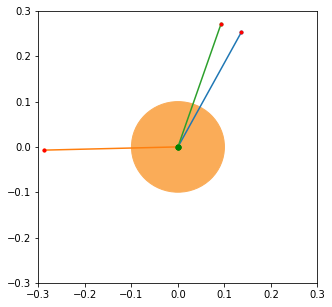

In [13]:
#layer1
walker_data = sorted(glob.glob('2D_walkers/2D_rand_0*.txt'))[:3]

fig, ax = plt.subplots(figsize = (5,5))
circ = plt.Circle((0,0),r_sample, color = '#FAAC58')
ax.add_artist(circ)
for walker in walker_data:
    color = next(ax._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=0:
        plt.plot(x,y,'.', color = color)
        plt.plot(x,y,'-', color = color)
        plt.plot(x[0], y[0], '.', color = 'green', ms = 10)
        plt.plot(x[-1], y[-1], '.', color = 'r')
plt.xlim(-3*r_sample, 3*r_sample)
plt.ylim(-3*r_sample, 3*r_sample)
#plt.savefig('2D_example_photon_walk_rand.pdf')
plt.show()   

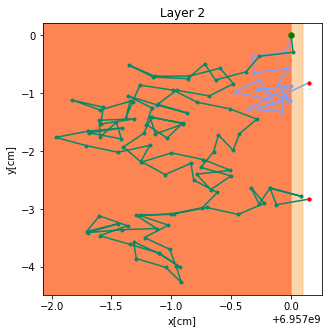

In [22]:
#layer2
walker_data = sorted(glob.glob('2D_walkers/2D_rand_1*.txt'))[:7]
custom_cycler = (cycler(color=['#9F81F7', '#819FF7', '#088A68']))
fig, ax = plt.subplots(figsize = (5,5))
circ = plt.Circle((0,0),section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section = plt.Circle((0,0),section, color = '#FE642E', alpha = 0.7)
ax.set_prop_cycle(custom_cycler)
ax.add_artist(circ)
ax.add_artist(r_section)
for walker in walker_data:
    color = next(ax._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        plt.plot(x,y,'.', color = color)
        plt.plot(x,y,'-', color = color)
        plt.plot(x[0], y[0], '.', color = 'green', ms = 10)
        plt.plot(x[-1], y[-1], '.', color = 'r')
plt.title('Layer 2')
plt.xlabel('x[cm]')
plt.ylabel('y[cm]')
plt.savefig('2D_sample_ex.pdf')
plt.show()   

In [16]:
import pylab
from cycler import cycler

custom_cycler = (cycler(color=['#9F81F7', '#0174DF', '#819FF7', '#088A68']))

fig, ax = plt.subplots(2,5,figsize = (20,10))

ax1 = plt.subplot(251, aspect='equal')
circ1 = plt.Circle((0,0),r_sample, color = '#FAAC58')
ax1.add_artist(circ1)
ax1.set_prop_cycle(custom_cycler)
walker_data1 = glob.glob('2D_walkers/2D_rand_0*.txt')[:3]
for walker in walker_data1:
    color = next(ax1._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=0:
        ax1.plot(x,y,'.', color = color)
        ax1.plot(x,y,'-', color = color)
        ax1.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax1.plot(x[-1], y[-1], '.', color = 'r')
ax1.set_title('Layer 1')
#ax1.set_xlabel('x[cm]')
#ax1.set_ylabel('y[cm]')
ax1.set_xlim(-3*r_sample, 3*r_sample)
ax1.set_ylim(-3*r_sample, 3*r_sample)

ax2 = plt.subplot(252, aspect='equal')
ax2.set_prop_cycle(custom_cycler)
circ2 = plt.Circle((0,0),section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section2 = plt.Circle((0,0),section, color = '#FE642E', alpha = 0.7)
ax2.add_artist(circ2)
ax2.add_artist(r_section2)
walker_data2 = glob.glob('2D_walkers/2D_rand_1*.txt')[:15]
for walker in walker_data2:
    color = next(ax2._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax2.plot(x,y,'.', color = color)
        ax2.plot(x,y,'-', color = color)
        ax2.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax2.plot(x[-1], y[-1], '.', color = 'r')
ax2.set_title('Layer 2')
#ax2.set_xlabel('x[cm]')
#ax2.set_ylabel('y[cm]')   

ax3 = plt.subplot(253, aspect='equal')
ax3.set_prop_cycle(custom_cycler)
circ3 = plt.Circle((0,0),2*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section3 = plt.Circle((0,0),2*section, color = '#FE642E', alpha = 0.7)
ax3.add_artist(circ3)
ax3.add_artist(r_section3)
walker_data3 = sorted(glob.glob('2D_walkers/2D_rand_2*.txt'))[:15]
for walker in walker_data3:
    color = next(ax3._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax3.plot(x,y,'.', color = color)
        ax3.plot(x,y,'-', color = color)
        ax3.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax3.plot(x[-1], y[-1], '.', color = 'r')
ax3.set_title('Layer 3')
#ax3.set_xlabel('x[cm]')
#ax3.set_ylabel('y[cm]')        

ax4 = plt.subplot(254, aspect='equal')
ax4.set_prop_cycle(custom_cycler)
circ4 = plt.Circle((0,0),3*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section4 = plt.Circle((0,0),3*section, color = '#FE642E', alpha = 0.7)
ax4.add_artist(circ4)
ax4.add_artist(r_section4)
walker_data4 = glob.glob('2D_walkers/2D_rand_3*.txt')[:15]
for walker in walker_data4:
    color = next(ax4._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax4.plot(x,y,'.', color = color)
        ax4.plot(x,y,'-', color = color)
        ax4.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax4.plot(x[-1], y[-1], '.', color = 'r')
ax4.set_title('Layer 4')
#ax4.set_xlabel('x[cm]')
#ax4.set_ylabel('y[cm]')       

ax5 = plt.subplot(255, aspect='equal')
ax5.set_prop_cycle(custom_cycler)
circ5 = plt.Circle((0,0),4*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section5 = plt.Circle((0,0),4*section, color = '#FE642E', alpha = 0.7)
ax5.add_artist(circ5)
ax5.add_artist(r_section5)
walker_data5 = glob.glob('2D_walkers/2D_rand_4*.txt')[:15]
for walker in walker_data5:
    color = next(ax5._get_lines.prop_cycler)['color'] 
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax5.plot(x,y,'.', color = color)
        ax5.plot(x,y,'-', color = color)
        ax5.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax5.plot(x[-1], y[-1], '.', color = 'r')
ax5.set_title('Layer 5')
#ax5.set_xlabel('x[cm]')
#ax5.set_ylabel('y[cm]')

ax6 = plt.subplot(256, aspect='equal')
ax6.set_prop_cycle(custom_cycler)
circ6 = plt.Circle((0,0),5*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section6 = plt.Circle((0,0),5*section, color = '#FE642E', alpha = 0.7)
ax6.add_artist(circ6)
ax6.add_artist(r_section6)
walker_data6 = glob.glob('2D_walkers/2D_rand_5*.txt')[:15]
for walker in walker_data6:
    color = next(ax6._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax6.plot(x,y,'.', color = color)
        ax6.plot(x,y,'-', color = color)
        ax6.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax6.plot(x[-1], y[-1], '.', color = 'r')
ax6.set_title('Layer 6')
#ax6.set_xlabel('x[cm]')
#ax6.set_ylabel('y[cm]')

ax7 = plt.subplot(257, aspect='equal')
ax7.set_prop_cycle(custom_cycler)
circ7 = plt.Circle((0,0),6*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section7 = plt.Circle((0,0),6*section, color = '#FE642E', alpha = 0.7)
ax7.add_artist(circ7)
ax7.add_artist(r_section7)
walker_data7 = glob.glob('2D_walkers/2D_rand_6*.txt')[:15]
for walker in walker_data7:
    color = next(ax7._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax7.plot(x,y,'.', color = color)
        ax7.plot(x,y,'-', color = color)
        ax7.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax7.plot(x[-1], y[-1], '.', color = 'r')
ax7.set_title('Layer 7')
#ax7.set_xlabel('x[cm]')
#ax7.set_ylabel('y[cm]') 

ax8 = plt.subplot(258, aspect='equal')
ax8.set_prop_cycle(custom_cycler)
circ8 = plt.Circle((0,0),7*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section8 = plt.Circle((0,0),7*section, color = '#FE642E', alpha = 0.7)
ax8.add_artist(circ8)
ax8.add_artist(r_section8)
walker_data8 = glob.glob('2D_walkers/2D_rand_7*.txt')[:15]
for walker in walker_data8:
    color = next(ax8._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax8.plot(x,y,'.', color = color)
        ax8.plot(x,y,'-', color = color)
        ax8.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax8.plot(x[-1], y[-1], '.', color = 'r')
ax8.set_title('Layer 8')
#ax8.set_xlabel('x[cm]')
#ax8.set_ylabel('y[cm]')

ax9 = plt.subplot(259, aspect='equal')
ax9.set_prop_cycle(custom_cycler)
circ9 = plt.Circle((0,0),8*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section9 = plt.Circle((0,0),8*section, color = '#FE642E', alpha = 0.7)
ax9.add_artist(circ9)
ax9.add_artist(r_section9)
walker_data9 = glob.glob('2D_walkers/2D_rand_8*.txt')[:15]
for walker in walker_data9:
    color = next(ax9._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    if np.shape(x)[0]>=15:
        ax9.plot(x,y,'.', color = color)
        ax9.plot(x,y,'-', color = color)
        ax9.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax9.plot(x[-1], y[-1], '.', color = 'r')
ax9.set_title('Layer 9')
#ax9.set_xlabel('x[cm]')
#ax9.set_ylabel('y[cm]')

ax10 = pylab.subplot(2,5,10)
ax10.set_prop_cycle(custom_cycler)
circ10 = plt.Circle((0,0),9*section+r_sample, color = '#FAAC58', alpha = 0.5)
r_section10 = plt.Circle((0,0),9*section, color = '#FE642E', alpha = 0.7)
ax10.add_artist(circ10)
ax10.add_artist(r_section10)
walker_data10 = glob.glob('2D_walkers/2D_rand_9*.txt')[:15]
for walker in walker_data10:
    color = next(ax10._get_lines.prop_cycler)['color']
    walk = np.genfromtxt(walker)
    x = walk[:,0]
    y = walk[:,1]
    x_array = []
    y_array = []
    if np.shape(x)[0]>=15:
        ax10.plot(x,y,'.', color = color)
        ax10.plot(x,y,'-', color = color)
        ax10.plot(x[0], y[0], '.', color = 'green', ms = 10)
        ax10.plot(x[-1], y[-1], '.', color = 'r')
ax10.set_title('Layer 10')
#ax10.set_xlabel('x[cm]')
#ax10.set_ylabel('y[cm]')

plt.savefig('phot_walk.png')   
plt.close()